### FNO Library

In [ ]:
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial
import datetime
#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [ ]:
import math
import torch
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)


class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss

In [ ]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation 
discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
# from utilities3 import *

# from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(7, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
################################################################
# configs
################################################################
sys_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/ARZ_sys_data.mat'
obs_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/ARZ_obs_data.mat'

In [ ]:
sys_reader = MatReader(sys_data_PATH)
sys_data = sys_reader.read_field('sys_data')

obs_reader = MatReader(obs_data_PATH)
obs_data = obs_reader.read_field('obs_data')

In [ ]:
sys_data.shape

torch.Size([1200, 101, 1201, 2])

In [ ]:
### Reshape the data into training data: xdata [#, 101, T, 2], ydata [#, 101, T, 1]
### For xdata: we need to get the initial condition obs[i, 0, :] --> 
num = 1200
nx = 101
nt = 1201
dim = 1 #0: density; 1: speed
x_data = torch.zeros((num, nx, nt, 5))
y_data = torch.zeros((num, nx, nt, 1))
truey_data = torch.zeros((num, nx, nt, 1))

In [ ]:
for i in range(num):
  
  # initial condition for density estimator
  init_cond = obs_data[i, :, 0, 0].reshape((-1, 1))
  init_cond = init_cond.repeat(1, nt)
  #print(init_cond.size())

  # density measurement at boundary 
  u_boundary_right = sys_data[i, nx-1, :, 0].reshape((1, -1))
  u_boundary_right = u_boundary_right.repeat(nx, 1)

  u_boundary_left = sys_data[i, 0, :, 0].reshape((1, -1))
  u_boundary_left = u_boundary_left.repeat(nx, 1)
  #print(u_boundary.size())

  # initial condition for speed estimator
  init_cond2 = obs_data[i, :, 0, 1].reshape((-1, 1))
  init_cond2 = init_cond2.repeat(1, nt)
  #print(init_cond.size())

  # speed measurement at boundary 
  u_boundary2 = sys_data[i, nx-1, :, 1].reshape((1, -1))
  u_boundary2 = u_boundary2.repeat(nx, 1)

  x_sample = torch.stack([init_cond, u_boundary_right, u_boundary_left, init_cond2, u_boundary2], dim = -1)
  #print('x_sample size', x_sample.size() )

  x_data[i, :] = x_sample

  ## observer output
  y_sample1 = torch.squeeze(obs_data[i, :, :, 0], -1)
  y_sample2 = torch.squeeze(obs_data[i, :, :, 1], -1)
  y_sample = torch.stack([y_sample1], dim = -1)
  #print('y_sample size', y_sample.size() )

  y_data[i, :] = y_sample

  ## true system dynamics
  truey_sample1 = torch.squeeze(sys_data[i, :, :, 0], -1)
  truey_sample2 = torch.squeeze(sys_data[i, :, :, 1], -1)
  truey_sample = torch.stack([truey_sample1], dim = -1)
  #print(truey_sample.size() )

  truey_data[i, :] = truey_sample

In [ ]:
# index = 2;
# f = plt.figure()
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), subplot_kw={"projection": "3d"})
# # Make data.
# X = np.arange(0, 101, 1)
# Y = np.arange(0, 1201, 1)
# X, Y = np.meshgrid(X, Y)
# vmax = np.max(sys_data[index, :, :, dim].detach().numpy())
# vmin = np.min(sys_data[index, :, :, dim].detach().numpy())


# # Plot the surface.
# surf1 = ax[0].plot_surface(X, Y, sys_data[index, :, :, dim].detach().numpy().T, cmap='jet', vmin=8, vmax=vmax)
# ax[0].set_ylabel('Time')
# ax[0].set_xlabel('loc')
# ax[0].set_zlim([8, vmax])
# ax[0].set_title('True System')
# surf2 = ax[1].plot_surface(X, Y, obs_data[index, :, :, dim].detach().numpy().T, cmap='jet', vmin=8, vmax=vmax)
# ax[1].set_ylabel('Time')
# ax[1].set_xlabel('loc')
# ax[1].set_zlim([8, vmax])
# ax[1].set_title('Observer')

# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(surf1, shrink=0.5, cax=cbar_ax)

In [ ]:
# plt.plot(sys_data[index, :, 500, dim].detach().numpy(), label = 'True')

# plt.plot(obs_data[index, :, 500, dim].detach().numpy(), label = 'Obs')

# plt.legend()

### Downsample to T = 121, NX = 101

In [ ]:
x_data2 = x_data[:, :, ::10, :]
y_data2 = y_data[:, :, ::10, :]
truey_data2 = truey_data[:, :, ::10, :]

# x_data2 = x_data
# y_data2 = y_data
# truey_data2 = truey_data

### Train FNO for Observer

In [ ]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = 101 #h
T = 1201 //10 + 1 #
# T = max_iter_time+1

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

In [ ]:
x_train = x_data2[:ntrain,:]
y_train = y_data2[:ntrain,:]
x_test = x_data2[-ntest:,:]
y_test = y_data2[-ntest:,:]
truey_test = truey_data2[-ntest:,:]

x_train = x_train.reshape(ntrain, s, T, 5)
x_test = x_test.reshape(ntest, s, T, 5)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [ ]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain, s, T, 5)
x_test = x_test.reshape(ntest, s, T, 5)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [ ]:
# model
model = FNO2d(modes, modes, width).cuda().cuda()
print(count_params(model))

2368129


In [ ]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, T, 1)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, s, T, 1)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_mse /= len(train_loader)
    train_l2/= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

0 3.486582563000013 1.9871695531037404e-05 0.034812139749526974 0.01903977870941162
1 3.218888657000008 3.751966287381947e-06 0.016564617455005645 0.014690949916839599
2 3.4804097509999963 2.963876422654721e-06 0.014664780050516128 0.013811701536178589
3 3.3591070740000077 2.662724741639977e-06 0.013882149696350097 0.01280972570180893
4 3.215235500999995 2.138656675469974e-06 0.012455197468400002 0.011110114902257918
5 3.3134507830000075 1.5770169534334855e-06 0.010792843639850617 0.010191062241792679


KeyboardInterrupt: ignored

In [ ]:
#torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/data/fno2d_traffic_density')
#torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/data/fno2d_traffic')

### Test Model and Visualize Results

In [ ]:
model = FNO2d(modes, modes, width).cuda().cuda()
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/data/fno2d_traffic'))

<All keys matched successfully>

In [ ]:
y_test.shape

torch.Size([100, 101, 121, 1])

In [ ]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size = 1, shuffle=False)
a = datetime.datetime.now()
test_mse = 0
batch_size = 1
index = 0
myloss = LpLoss(size_average=False)
y_normalizer.cuda()

with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x) #.view(-1)

        out = y_normalizer.decode(out)
        # y = y_normalizer.decode(y)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')

        test_mse += mse.item()
        
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        #print(index, test_l2)
        index = index + 1
    
    test_mse /= len(test_loader)
    print('Test MSE', test_mse)

    test_l2 /= len(test_loader)
    print('test_l2', test_l2)
    
    b = datetime.datetime.now()
    print('Test on 100 data points', (b-a)/100)

Test MSE 8.934738831456457e-08
test_l2 2.4057833943516016e-05
Test on 100 data points 0:00:00.007416


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

In [ ]:
truey_test[index, :, :, 0].detach().numpy().shape

(101, 121)

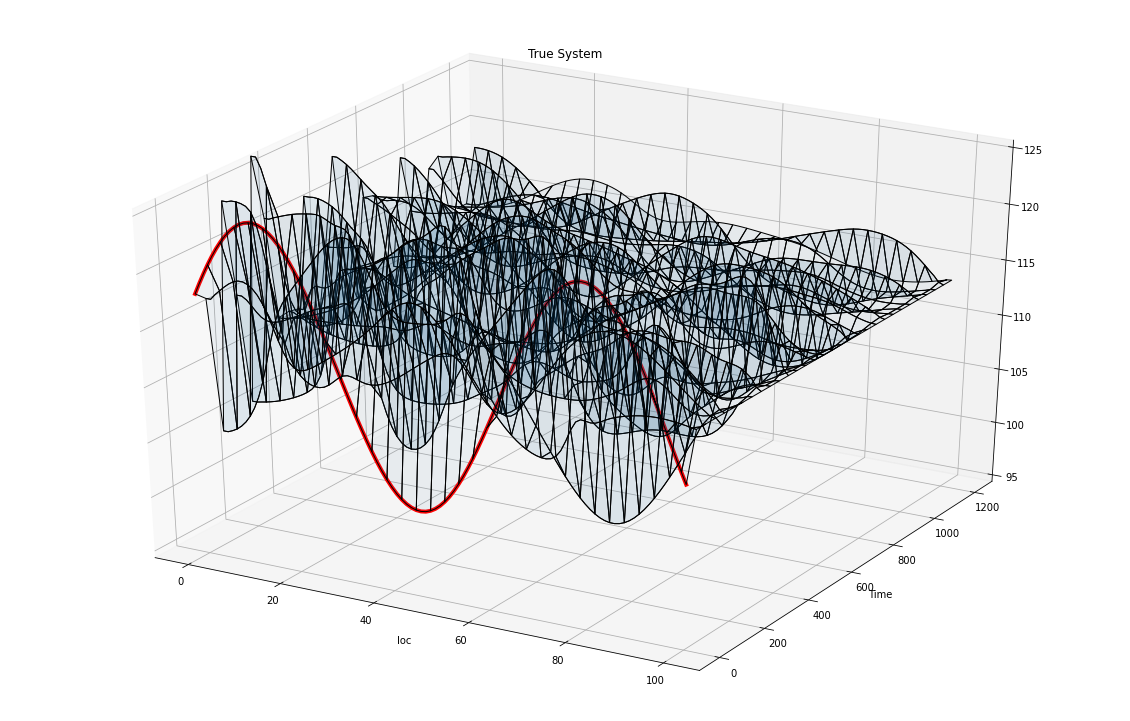

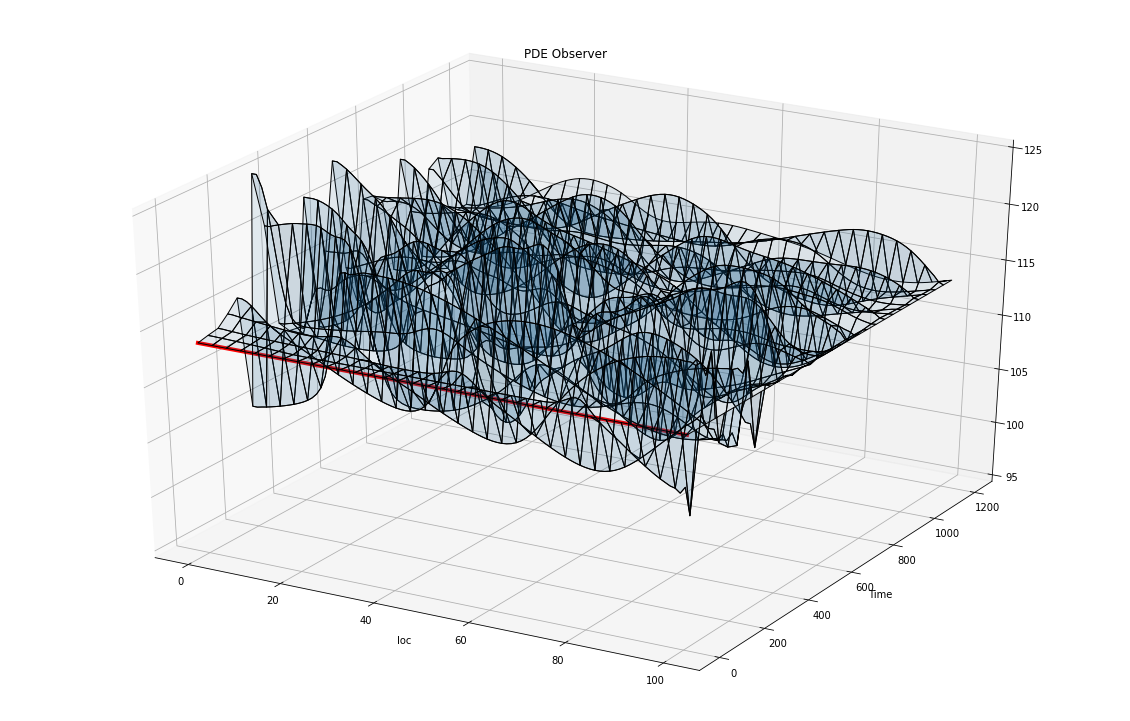

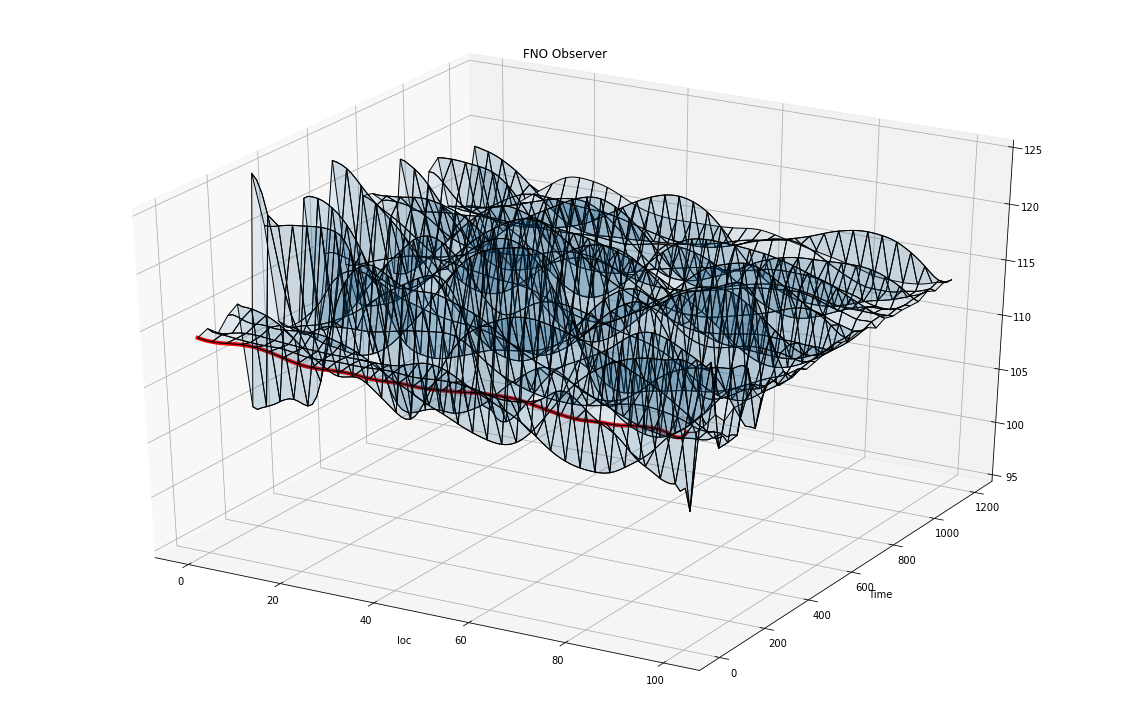

In [ ]:
from pyparsing.core import White
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as spint
from matplotlib import cm

my_cmap = plt.get_cmap('cool') 


index = 96

# f = plt.figure()

# # Make data.
X = np.arange(0, 101, 1)
Y = np.arange(0, 1201, 40)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())
vmin = np.min(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 13), subplot_kw={"projection": "3d"})
surf1 = ax1.plot_surface(X, Y, 1000*truey_test[index, :, ::4, 0].detach().numpy().T, edgecolors='k', linewidth=1, alpha=0.06)
ax1.set_xlabel('loc')
ax1.set_ylabel('Time')
ax1.set_zlim([95, 125])
ax1.set_title('True System')
# fig1.colorbar(surf1, ax = ax1, shrink = 0.7, aspect = 7) 
inity = 1000*truey_test[index, :, 0, 0].detach().numpy()
bound = 1000*y_test[index, -1, :, 0].detach().numpy()
ax1.plot3D(np.arange(0, 101, 1), 0*np.arange(0, 101, 1), inity, color='red', linewidth=4)
#ax1.plot3D(100*np.ones_like(np.arange(0, 1201, 10)), np.arange(0, 1201, 10), bound, color='blue', linewidth=4)


fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 13), subplot_kw={"projection": "3d"})
surf2 = ax2.plot_surface(X, Y, 1000*y_test[index, :, ::4, 0].detach().numpy().T, edgecolors='k', linewidth=1, alpha=0.1)
ax2.set_xlabel('loc')
ax2.set_ylabel('Time')
ax2.set_zlim([95, 125])
ax2.set_title('PDE Observer')
inity_obs = 1000*y_test[index, :, 0, 0].detach().numpy()
bound_obs = 1000*y_test[index, -2, :, 0].detach().numpy()
ax2.plot3D(np.arange(0, 101, 1), 0*np.arange(0, 101, 1), inity_obs, color='red', linewidth=4)
#ax2.plot3D(100*np.ones_like(np.arange(0, 1201, 10)), np.arange(0, 1201, 10), bound_obs, color='blue', linewidth=4)

fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(20, 13), subplot_kw={"projection": "3d"})
surf3 = ax3.plot_surface(X, Y, 1000*pred[index, :, ::4, 0].detach().numpy().T, edgecolors='k', linewidth=1, alpha=0.1)
ax3.set_xlabel('loc')
ax3.set_ylabel('Time')
ax3.set_title('FNO Observer')
ax3.set_zlim([95, 125])
inity_fno = 1000*pred[index, :, 0, 0].detach().numpy()
bound_fno = 1000*pred[index, -2, :, 0].detach().numpy()
ax3.plot3D(np.arange(0, 101, 1), 0*np.arange(0, 101, 1), inity_fno, color='red', linewidth=4)
#ax3.plot3D(100*np.ones_like(np.arange(0, 1201, 10)), np.arange(0, 1201, 10), bound_fno, color='blue', linewidth=4)


# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(surf1, shrink=0.5, cax=cbar_ax)
#fig.colorbar(surf1, shrink=0.5, aspect=5)

# plt.show()
# f.savefig('test1.eps', format='eps')

[Text(0, 0, '0'),
 Text(0, 0, '40'),
 Text(0, 0, '80'),
 Text(0, 0, '120'),
 Text(0, 0, '160'),
 Text(0, 0, '200'),
 Text(0, 0, '240')]

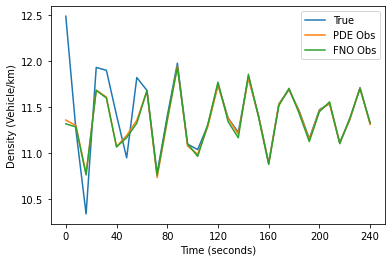

In [ ]:
fig = plt.figure()
ax = fig.gca()
plt.plot(100*truey_test[index, 80, ::4, 0], label = 'True')
plt.plot(100*y_test[index, 80, ::4, 0], label = 'PDE Obs')
plt.plot(100*pred[index, 80, ::4, 0], label = 'FNO Obs')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Density (Vehicle/km)')
ax.set_xticks([0, 5, 10, 15, 20, 25, 30]) # values
ax.set_xticklabels([0, 40, 80, 120, 160, 200, 240]) # labels

In [ ]:
from numpy import linalg as LA

In [ ]:
index = 96
error1norm=np.zeros(T,);
error2norm=np.zeros(T,);
error1 = np.zeros((nx, T))
error2 = np.zeros((nx, T))
for k in range(T):
  error1[:, k] = y_test[index, :, k, 0].detach().numpy() - truey_test[index, :, k, 0].detach().numpy();  
  error2[:, k] = pred[index, :, k, 0].detach().numpy() - truey_test[index, :, k, 0].detach().numpy();  
  error1norm[k] = LA.norm(error1[:, k])
  error2norm[k] = LA.norm(error2[:, k])

[Text(0, 0, '0'),
 Text(0, 0, '40'),
 Text(0, 0, '80'),
 Text(0, 0, '120'),
 Text(0, 0, '160'),
 Text(0, 0, '200'),
 Text(0, 0, '240')]

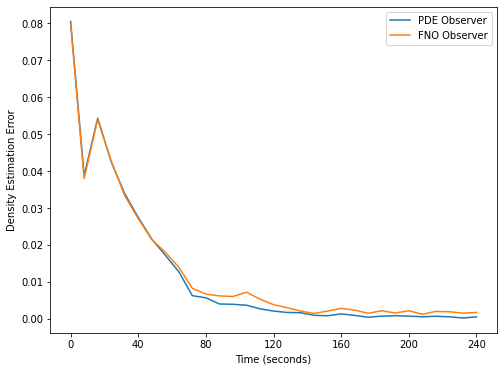

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
plt.plot(error1norm[::4], label = 'PDE Observer')
plt.plot(error2norm[::4], label = 'FNO Observer')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Density Estimation Error')
ax.set_xticks([0, 5, 10, 15, 20, 25, 30]) # values
ax.set_xticklabels([0, 40, 80, 120, 160, 200, 240]) # labels

In [ ]:
from google.colab import files
files.download('test1.eps') 

FileNotFoundError: ignored

### Make Plots (Backup)

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

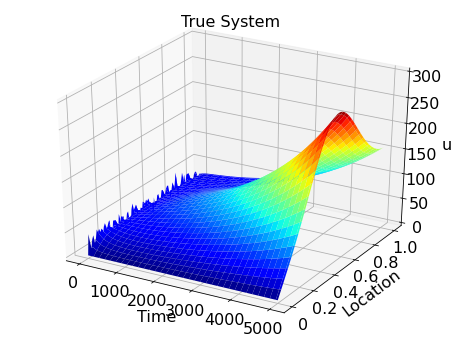

In [ ]:
index = 81
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, truey_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
# ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000]) # values
# ax.set_xticklabels([0, 0.025, 0.05, 0.075, 0.1, 0.125]) # labels
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('True System')
ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

from google.colab import files
plt.savefig(
    'truey_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('truey_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

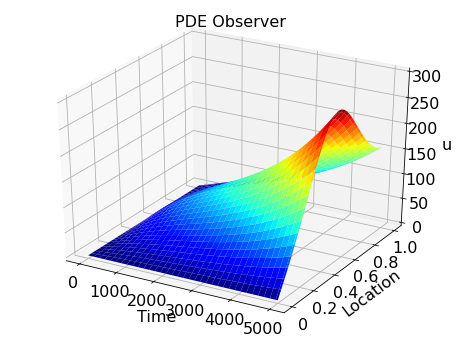

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

index = 81

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, y_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('PDE Observer')
ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('obs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

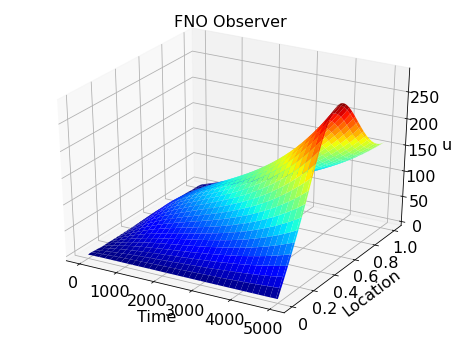

In [ ]:
index = 81

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, pred2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('FNO Observer')
# ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'fno_obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('fno_obs_text{}.eps'.format(index)) 

296.3208


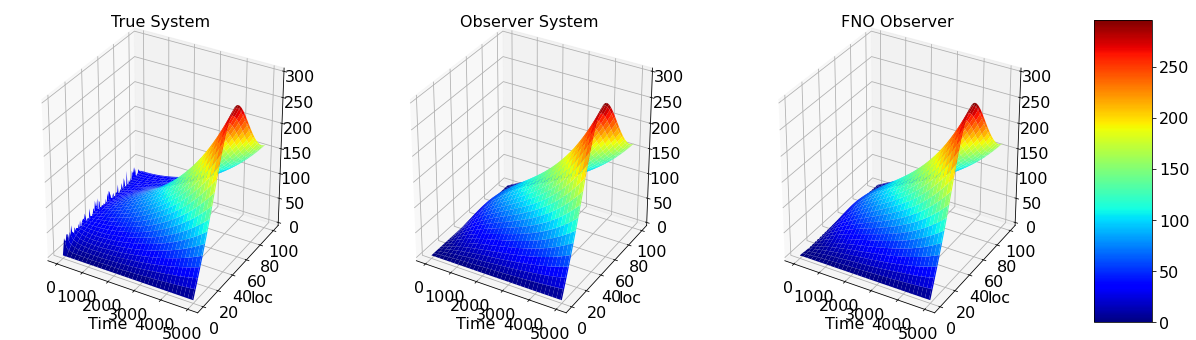

In [ ]:
index = 81

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())
print(vmax)

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, truey_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_title('True System')
ax[0].set_zlim([0, 300])
surf2 = ax[1].plot_surface(X, Y, y_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, 300])
ax[1].set_title('Observer System')
surf3 = ax[2].plot_surface(X, Y, pred2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('loc')
ax[2].set_zlim([0, 300])
ax[2].set_title('FNO Observer')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(surf1, shrink=0.5, cax=cbar_ax, aspect=5)
#fig.colorbar(surf1, shrink=0.5, aspect=5)

plt.show()

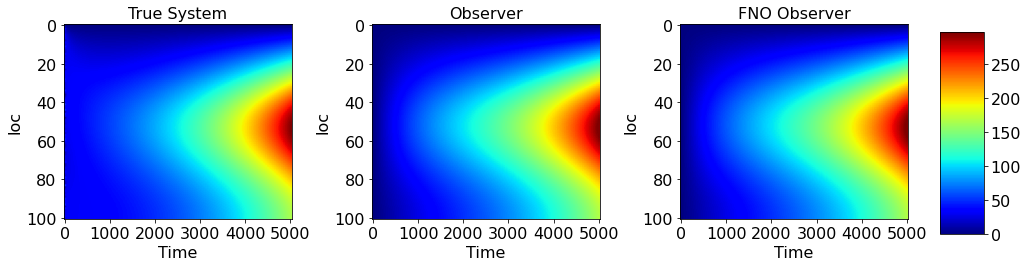

In [ ]:
index = 81
vmax = truey_test2[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.tight_layout()
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

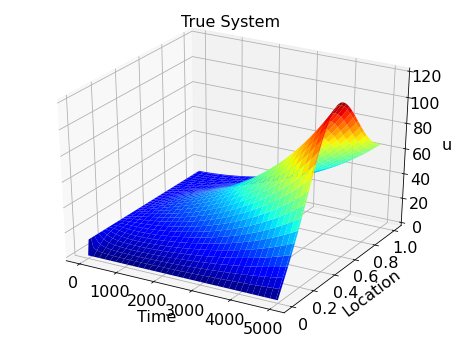

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, truey_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('True System')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'truey_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('truey_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

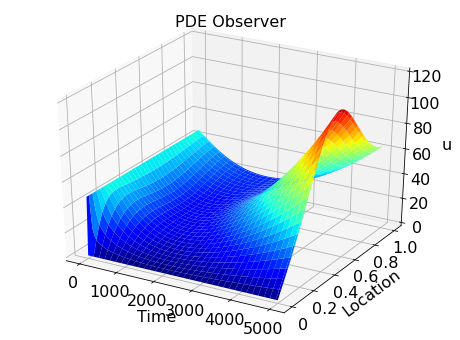

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('PDE Observer')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('obs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

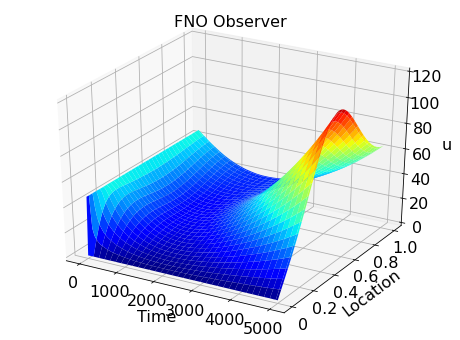

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, pred[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.tick_params(axis='both', which='major', pad=2)
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_yticks([0, 20, 40, 60, 80, 100]) # values
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_zlabel('u')
ax.set_title('FNO Observer')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'fno_obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('fno_obs_text{}.eps'.format(index)) 

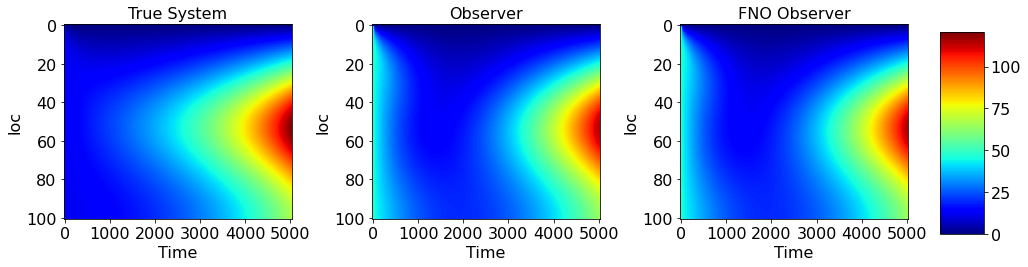

In [ ]:
index = 84
vmax = truey_test[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.tight_layout()
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

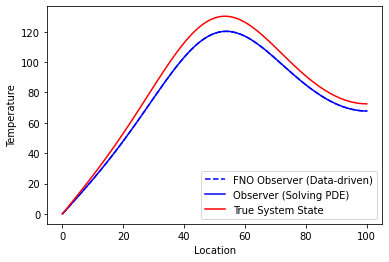

In [ ]:
plt.plot(pred[index, :, -1, 0], 'b--', label = 'FNO Observer (Data-driven)')
plt.plot(y_test[index, :, -1, 0], 'b', label = 'Observer (Solving PDE)')
plt.plot(truey_test[index, :, -1, 0], 'r', label = 'True System State')
plt.xlabel('Location')
plt.ylabel('Temperature')

plt.legend()